In [1]:
import os
import time

import cv2 as cv
import numpy as np
from math import sin, cos, tan
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Conv2D, Flatten, MaxPooling2D
from keras.models import model_from_json, Model
import keras.backend as K
import keras.layers as KL
import keras

Using TensorFlow backend.


In [2]:
# Neural net setup
BINS_EDGE = np.load("./nn_data/s1p10_bins_edge.npy")
NUM_LABELS = 10
NUM_CLASSES = len(BINS_EDGE) - 1
NUM_SMOOTH = 3

In [3]:
def convolutional_block(X, num_filters, shape_filters, strides, stage):
    """
    Implementation of convolutional block in Residual network
    
    Input:
        X (tensor): input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        num_filters (list of 3 ints): list of number of filters
        shape_filters (list of 3 ints): list of filters' shape
        strides (list of 3 ints): list of strides
        stage (int): stage of this convolutional block in the whole ResNet
        
    Output:
        tensor of shape (m, n_H, n_W, n_C)
    """
    
    # retrieve filters shape from filters
    n1, n2, n3 = num_filters
    f1, f2, f3 = shape_filters
    
    # retrieve strides from strides
    s1, s2, s3 = strides
    
    # create name
    bn_name_base = 'bn_' + str(stage) + '_'
    conv_name_base = 'conv_' + str(stage) + '_'
    
    # save value of X
    X_shorcut = X
    
    # First component of the main path
    X = BatchNormalization(name=bn_name_base + 'a')(X)
    X = Activation('relu', name="feature_map_%d" % (stage - 1))(X)
    X = Conv2D(n1, (f1, f1), strides=[s1, s1], padding='same',
               name=conv_name_base + 'a')(X)
    
    # Second component of the main path
    X = BatchNormalization(name=bn_name_base + 'b')(X)
    X = Activation('relu')(X)
    X = Conv2D(n2, (f2, f2), strides=[s2, s2], padding='same',
               name=conv_name_base + 'b')(X)
    
    # Short-cut
    X_shorcut = Conv2D(n3, (f3, f3), strides=[s3, s3], padding='same', 
                       name=conv_name_base + 'c')(X_shorcut)
    
    X = KL.merge.add([X, X_shorcut])
    
    return X
def full_model(input_shape):
    """
    Define encoder architecture as ResNet8
    
    Input:
        input_shape (list of ints): shape of input image [n_H, n_W, n_C]
        
    Output:
        model: a Model instance
    """
    
    # Input
    X_input = Input(shape=input_shape)
    
    # Apply 1st convolution & max pooling on input
    X = Conv2D(32, (5, 5), strides=[2,2], padding='same', name='conv_0')(X_input)
    X = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(X) 
    
    # First convolutional block
    X = convolutional_block(X, [32, 32, 32], [3, 3, 1], [2, 1, 2], stage=1)
    
    # Second convolutional block
    X = convolutional_block(X, [64, 64, 64], [3, 3, 1], [2, 1, 2], stage=2)
    
    # Third convolutional block
    X = convolutional_block(X, [128, 128, 128], [3, 3, 1], [2, 1, 2], stage=3)
    
    # Output layer of resnet-8
    X = Flatten()(X)
    X = Activation('relu')(X)
    
    # extract feature vector
    X_feature = Dropout(0.5)(X)
    
    # apply classifier body
    X_body = Dense(800, activation='relu')(X_feature)
    
    # apply classifier head
    y = []
    for i in range(NUM_LABELS):
        X_body_1 = Dropout(0.5)(X_body)
        out = Dense(NUM_CLASSES, activation='softmax', name="head_%d" % i)(X_body_1)
        y.append(out)
    
    model = Model(inputs=[X_input], outputs=y)    
    return model

In [5]:
MODEL_DIR = "./nn_data/"    
model_list = [full_model((200, 200, 1)) for i in range(6)]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# Get image name
WEIGHT_DIR = MODEL_DIR + "model_checkpoint/"
weight_list = []
for (dirpath, dirnames, filenames) in os.walk(WEIGHT_DIR):
    weight_list.extend(filenames)
    break
weight_list.sort()

In [7]:
weight_list

['initial_weights.hdf5',
 'weights-05-16.4251.hdf5',
 'weights-10-12.2251.hdf5',
 'weights-15-10.4523.hdf5',
 'weights-20-8.9884.hdf5',
 'weights-25-8.5545.hdf5']

In [8]:
for model, weight in zip(model_list, weight_list):
    model.load_weights(WEIGHT_DIR + weight)

In [9]:
# Get image name
img_dir = "/home/user/Bureau/Dataset/udacity/Ch2_001/center"
img_name = "1479425721881751009.jpg"


file_name = os.path.join(img_dir, img_name)
img = cv.imread(file_name, 0)
# get bottom half
bottom_half = img[100 :, :]

# down sample & reshape image
img = np.float32(cv.resize(bottom_half, (200, 200), interpolation=cv.INTER_AREA))
if len(img.shape) == 2:
    img = img.reshape((200, 200, 1))

# put image into tensor    
X = np.zeros((1, 200, 200, 1))
X[0, :, :, :] = img

In [10]:
def get_layer_activation(model, layer_index, X):
    """
    Get activation of a specific layer
    
    Input:
        model (keras.model)
        layer_index (int): index of the layer want to get activation. Started from 0 for the Input layer
        X (np.ndarray) - shape (1, 200, 200, 1): 1 test image
    
    Output:
        np.ndarray - shape is the output shape of the layer of interest (without batch size)
    """
    inp = model.input
    out = [model.layers[layer_index].output]  # get layer output
    functor = K.function([inp, K.learning_phase()], out)   # evaluation function
    layer_out = functor([X, 1.])
    return layer_out[0]

In [11]:
model_list[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 100, 100, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 49, 49, 32)   0           conv_0[0][0]                     
__________________________________________________________________________________________________
bn_1_a (BatchNormalization)     (None, 49, 49, 32)   128         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
feature_ma

Text(0.5, 1.0, 'Input to netowrk (crop image)')

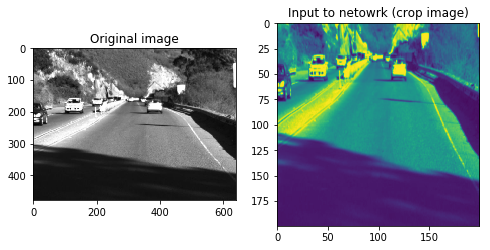

In [27]:
original_img = cv.imread(file_name, 0)
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(original_img, cmap='gray')
plt.title("Original image")
plt.subplot(122)
plt.imshow(X[0, :, :, 0])
plt.title("Input to netowrk (crop image)")

In [29]:
# Get feature_map_0 (Activation) 
feat_map_0_list = [get_layer_activation(model, 4, X) for model in model_list]
# Get feature_map_1 (Activation) 
feat_map_1_list = [get_layer_activation(model, 12, X) for model in model_list]
# Get feature_map_2 (Activation) 
feat_map_2_list = [get_layer_activation(model, 20, X) for model in model_list]

In [30]:
print("feat_map_0 shape:", feat_map_0_list[0].shape)
print("feat_map_1 shape:", feat_map_1_list[0].shape)
print("feat_map_2 shape:", feat_map_2_list[0].shape)

feat_map_0 shape: (1, 49, 49, 32)
feat_map_1 shape: (1, 25, 25, 32)
feat_map_2 shape: (1, 13, 13, 64)


# Visualize Activation of ResNet Block

The first feature map is associated with the initial weights (randomly initialized). The last feature map corresponds to the trained weights after 28 epochs (stop because of drop out).

In between, from top to bottom, feature maps after every 5 epochs. 

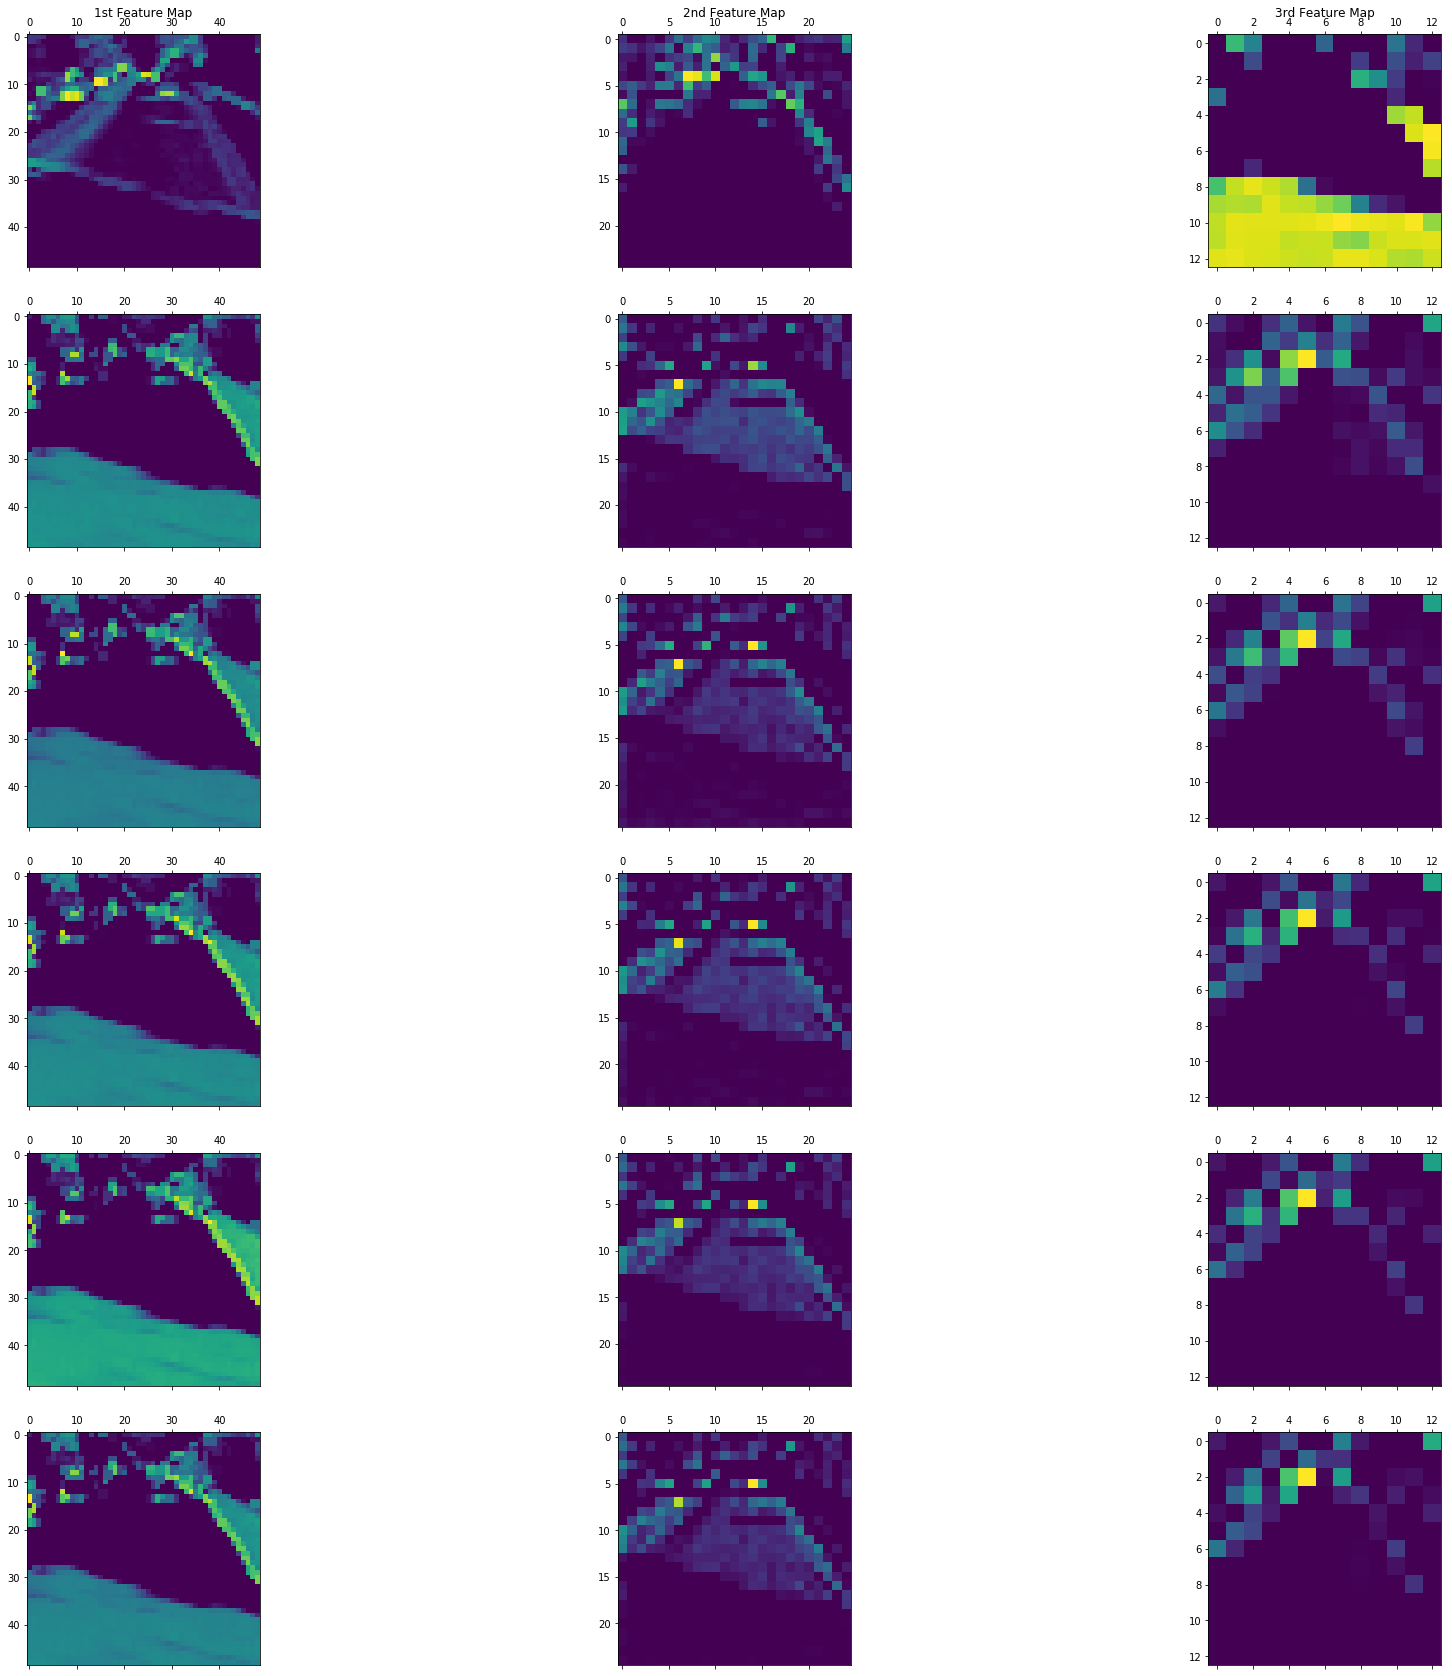

In [107]:
plt.figure(figsize=(30, 30))
row = 0
for f0, f1, f2 in zip(feat_map_0_list, feat_map_1_list, feat_map_2_list):
    plt.subplot(6, 3, 3*row + 1)
    if row == 0:
        plt.title("1st Feature Map")
    plt.matshow(f0[0, :, :, 0], cmap='viridis', fignum=False)
    plt.subplot(6, 3, 3*row + 2)
    if row == 0:
        plt.title("2nd Feature Map")
    plt.matshow(f1[0, :, :, 0], cmap='viridis', fignum=False)
    plt.subplot(6, 3, 3*row + 3)
    if row == 0:
        plt.title("3rd Feature Map")
    plt.matshow(f2[0, :, :, 58], cmap='viridis', fignum=False)
    row += 1